In [ ]:
import janestreet
import datatable as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from tqdm.notebook import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [16, 5]  # width, height

In [ ]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
%%time

train_data = (
    dt.fread('../input/jane-street-market-prediction/train.csv')
      .to_pandas()
      .query('weight > 0')
)

This notebook presents two ideas for target enginnering:
- Training on **cross-sectional daily bins** of `weight` x `resp`
- Training on **two** targets simultaneiously

# Why Target Engineering?

In low signal-to-noise prediction problems, it is very difficult to build a robust model. One way to aid in robustness is to engineer the target. In fact, most everyone in this competition is already doing this with something like

```y = (train_data['resp'] > 0).astype(int)```


to make a binary target for use in a classifier. Can we do "better" than this?

As noted in the great notebook [The Most Important Model Parameter](https://www.kaggle.com/gkoundry/the-most-important-model-parameter), there is a drift in the mean daily return, `resp`, and this drift is different when  you account for the `weight`:

In [ ]:
(1+(train_data.groupby('date')['resp'].mean())).cumprod().plot();
train_data['weight_x_resp'] = train_data['weight']*train_data['resp']
(1+(train_data.groupby('date')['weight_x_resp'].mean())).cumprod().plot();
plt.legend();

How do we account for this drift in the modeling process? The referenced notebook indicated that one could tune the classifier decision boundary, noting that this is likely just overfitting to the public leaderboard.

## Cross Sectional Daily Bins

Since `weight` is strictly positive, it doesn't help to engineer the `resp` target simply by multiplying by `weight`. However, one approach to engineer the target and "solve" this is to quantile the `resp x weight` per day and then set the target to be the top N bins. This approach focuses the classifer to train on high return **and** high weight trades. It removes, in training, any drift in the dataset.

In [ ]:
plt.scatter(train_data['weight'], train_data['resp'], alpha=0.25);
plt.xlabel('weight');
plt.ylabel('resp');

The weights are log-normally distributed. A simple log transform shows this.

In [ ]:
np.log(train_data['weight']).hist(bins=50);
plt.xlabel('Histogram bin of ln(weight)');

In [ ]:
bins = 100

In [ ]:
train_data['daily_wr_bin'] = (
    train_data.groupby('date')['weight_x_resp']
              .apply(pd.qcut, q=bins, labels=False)
)

If we quantile the `weight_x_resp`, we see that most of the trades are in the tails.

In [ ]:
plt.scatter(train_data['daily_wr_bin'], train_data['weight_x_resp'], alpha=0.25);
plt.axvline(bins//2, linestyle='--', c='r');
plt.xlabel('Daily Bin');
plt.ylabel('weight_x_resp');

In [ ]:
train_data['bin_resp'] = (train_data['daily_wr_bin'] > bins//2).astype(int)

In [ ]:
imp_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()
lr = LogisticRegression(C=0.1, max_iter=1000)

pipe = Pipeline(steps=[
    ('imputer', imp_mean),
    ('scaler', scaler),
    ('lr', lr)
])

pipe

In [ ]:
cv = PurgedGroupTimeSeriesSplit(
    n_splits=3,
    max_train_group_size=150,
    group_gap=20,
    max_test_group_size=60
)


In [ ]:
X = train_data[train_data.columns[train_data.columns.str.contains('feature')]].values
groups = train_data['date'].values

In [ ]:
def run_cv(pipe, X, y, cv, groups, scoring='roc_auc'):
    cv_scores = cross_val_score(pipe, X, y, cv=cv, groups=groups, scoring=scoring)
    print(cv_scores)
    print(f'mean: {np.mean(cv_scores)}   std: {np.std(cv_scores)}')

In [ ]:
%%time
y = (train_data['resp']>0).astype(int).values
run_cv(pipe, X, y, cv=cv, groups=groups)

In [ ]:
%%time
y = train_data['bin_resp'].values
run_cv(pipe, X, y, cv=cv, groups=groups)

So we do see some greater ability to predict if a `weight_x_resp` will be in the top half. It remains to be seen if this correlates better with higher utility.

# A Multi-Target Approach


In this competition, we are provided with sequential trading opportunities and we need to decide "yes"/"no" as to do the trade or not; the sponsor provides anonymous features. The ultimate score is a function of the `resp` target, which is a (presumably raw) future return of unknown horizon. The motivation here is to take advantage of `resp_1`, `resp_2`, `resp_3`, and `resp_4`. Per the comptition intro 

> In the training set, train.csv, you are provided a resp value, as well as several other resp_{1,2,3,4} values that represent returns over different time horizons. These variables are not included in the test set.

And as noted/suggested by the sponsor in [this comment](https://www.kaggle.com/c/jane-street-market-prediction/discussion/198965#1088950)

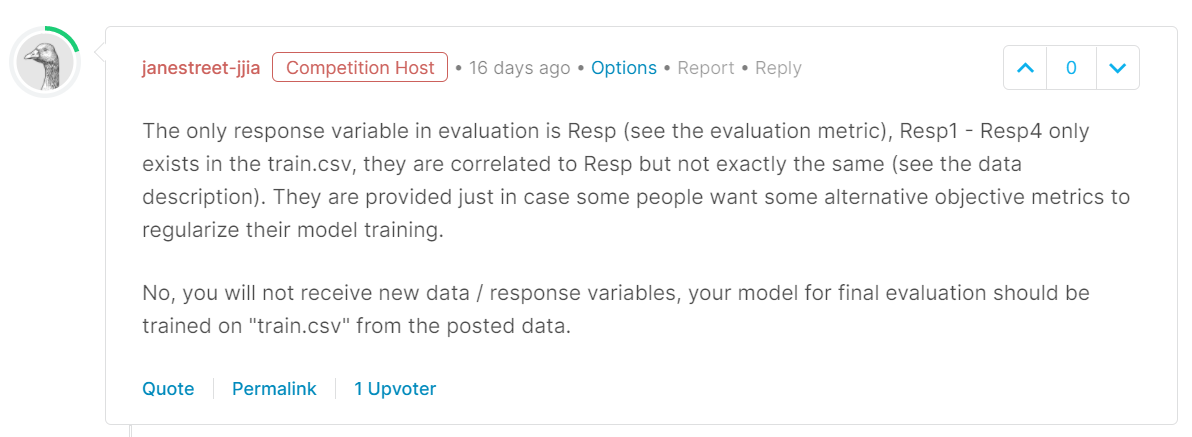


**So the idea is that perhaps a model which is robust to predicting returns at multiple horizons will be more robust at predicting the single horizon competition target, `resp`.**

## A Corollary to the Triple Barrier Method

It is not clear what the resp_ time horizons are. It is well known that quant models which predict for time *t+1* are often unsuitable for predicting at time *t+2* if the time step is large. However, the reverse is posited to be: models which predict *t+1* **are more robust** if they are able to predict at time *t+f* where *f < 1*. If we can simultaneously predict at multiple horizons up to t+1 then we capture path dynamics. The loss function must include the combined loss of all horizons.

This idea is similar to the so-called "triple barrier method" postited by Lopez de Prado in [Advances in Financial Machine Learning](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089/ref=sr_1_1?crid=29OT5YAU1GUMZ&dchild=1&keywords=advances+in+financial+machine+learning&qid=1607535288&sprefix=advances+%2Caps%2C184&sr=8-1):

The idea he proposes implies that the path of the stock, from prediction t to the final horizon time, matters. In this formulation however there is still only **one label**. That single label is a function of the path.

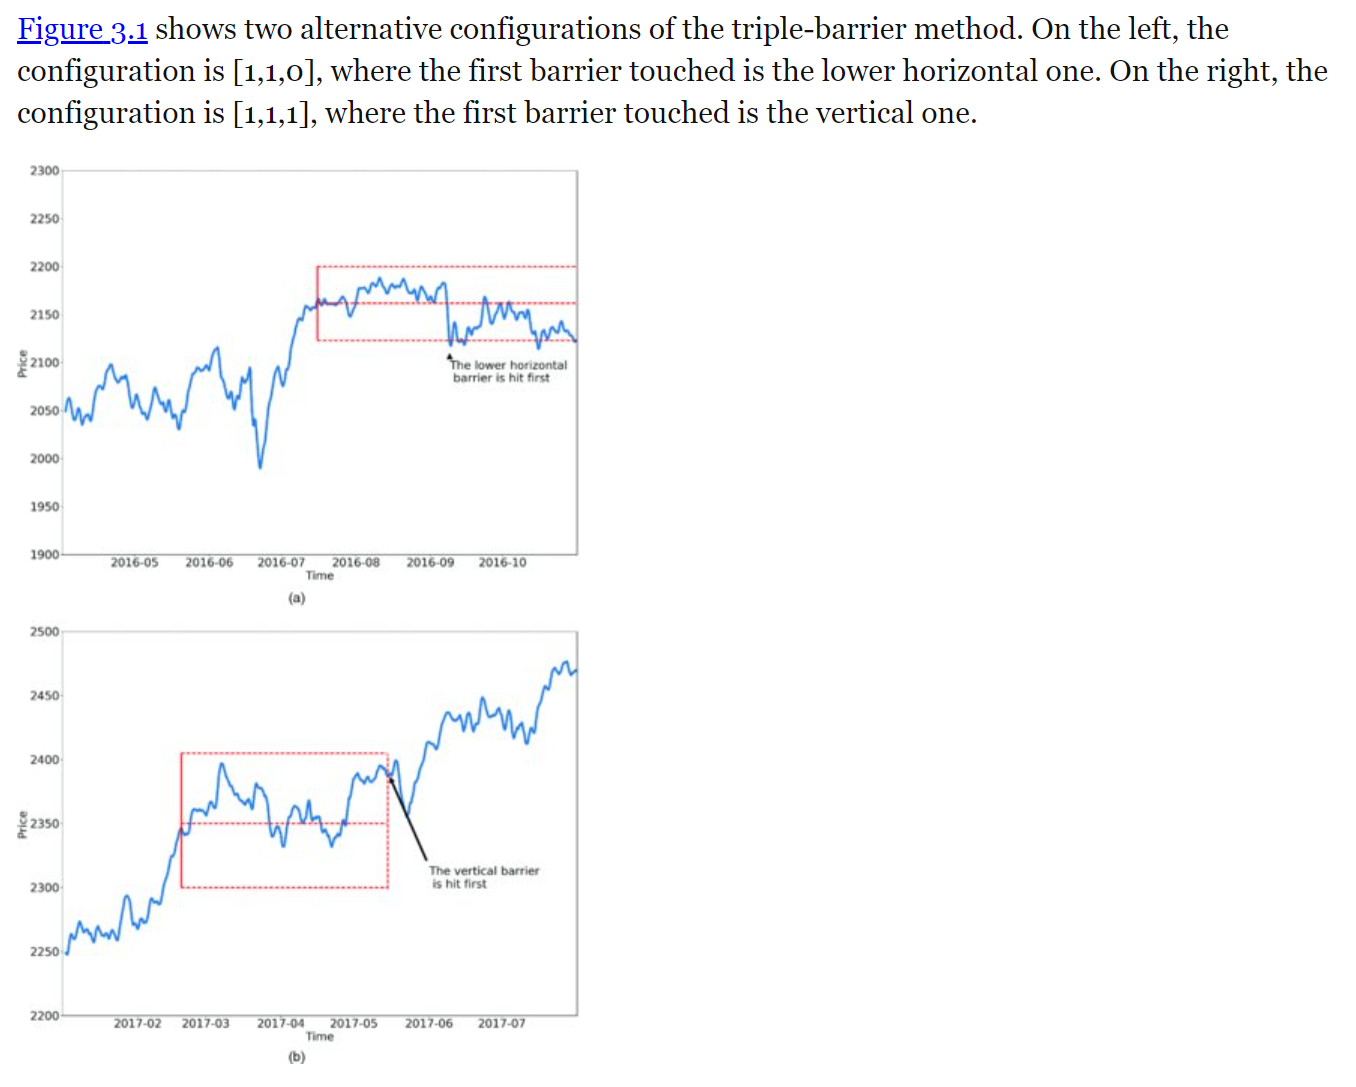
Source: LdP, Advances in Financial Machine Learning, chapter 3.


The key idea in this notebook is that if we can convince ourselves that one or more of the `resp_{1,2,3,4}` variables is shorter in time than `resp`, then we should get a more robust model with multi-target training. We want a loss function in our model which takes into account the model's ability to **predict at all relevant horizons**. We can't do this with traditional ML or GBDT modles like XGBoost or LightGBM, we need a deep learning model.

Read train data.

In [ ]:
train_data.head()

# What is the Time Ordering of responses?

I believe that `resp_1 < resp_2 < resp_3 < resp < resp_4`. Why is this? A stylized feature of financial time series is that the variance scales with time. In a perfectly efficient market, the variance scales linearly with time (i.e., the price series is a random walk). Thus we can order the resp_x labels in time by looking at their variances. Simple plots make this clear.

In [ ]:
train_data[['resp', 'resp_1']].plot();

In [ ]:
train_data[['resp', 'resp_2']].plot();

In [ ]:
train_data[['resp', 'resp_3']].plot();

In [ ]:
train_data[['resp', 'resp_4']].plot();

In [ ]:
resps = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']
resp_stds = (train_data[resps]
    .std()
    .sort_values()
);
ax = resp_stds.plot(kind='bar', title='Standard Deviation of each `resp_`')
for bar in ax.patches:
    bar.set_facecolor('#aa3333')
pos = resp_stds.index.get_loc('resp')
ax.patches[pos].set_facecolor('#348ABD')

Now to the model. Since we beleive that `resp_{1,2,3}` come *before* `resp` in time, we can use these returng to make our model more robust to overfitting.

The sponsor also includes a "weight" indicator for the trade. This is a scalar that multiplies the `resp` in the score. As noted elsewhere, I believe the weight to be an inverse function of the expected transaction cost to do the trade. There are many zero weights in the training data and we want to remove these.

In [ ]:
train_data['resp_target'] = (train_data['resp'] > 0).astype(np.int8)
train_data['resp_1_target'] = (train_data['resp_1'] > 0).astype(np.int8)
train_data['resp_2_target'] = (train_data['resp_2'] > 0).astype(np.int8)
train_data['resp_3_target'] = (train_data['resp_3'] > 0).astype(np.int8)
train_data['resp_4_target'] = (train_data['resp_4'] > 0).astype(np.int8)

# TARGET_NAMES = [
#     'resp_target', 'resp_1_target', 'resp_2_target', 'resp_3_target' ,'resp_4_target'
# ]

# TARGET_NAMES = [
#     'resp_target'
# ]

# I am going to train againt only two targets
TARGET_NAMES = [
    'resp_target', 'resp_2_target'
]

FEATURE_NAMES = train_data.columns[train_data.columns.str.contains('feature')]

In [ ]:
train_means = train_data.mean()
train_data.fillna(train_means, inplace=True)

In [ ]:
import gc
gc.collect()

# fastai Code

Using the fastai classes, we can train a DL model with just a tiny bit of code.

In [ ]:
from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.learner import TabularLearner
from fastai.callback.schedule import fit_one_cycle, lr_find  # this is monkey patched 

First we need a model. This is pure PyTorch.

In [ ]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets):
        super().__init__()

        dropouts = [0.10, 0.20, 0.25, 0.25, 0.25]
        hidden_size = [384, 896, 896, 384]
        
        layers = [nn.BatchNorm1d(num_features)]
        in_size = num_features

        for i in range(len(hidden_size)):
            out_size = hidden_size[i]
            layers.append(nn.Dropout(dropouts[i]))
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.BatchNorm1d(out_size))
            layers.append(nn.SiLU())  # SiLU aka swish
            in_size = out_size

        layers.append(nn.Dropout(dropouts[-1]))
        layers.append(nn.Linear(in_size, num_targets))
        layers.append(nn.Sigmoid())
        
        self.model = torch.nn.Sequential(*layers)

    def forward(self, cat, cont):
        # fastai tabular passes categorical and continuous features separately
        x = self.model(cont)
        return x

In [ ]:
NUM_FEATURES = len(FEATURE_NAMES)
NUM_TARGETS = len(TARGET_NAMES)
BATCH_SIZE = 4096
EPOCHS = 5

In [ ]:
# this should not be necessary IMHO, but I think there is a bug somewhere that
# requries this to avoid. see https://forums.fast.ai/t/tabular-learner-error-found-dtype-char-but-expected-float/77245/2
train_data[TARGET_NAMES] = train_data[TARGET_NAMES].astype(np.float32)

In [ ]:
# get indices for the validation set
n_samples = len(train_data)
split_idx = int(n_samples*0.70)
val_idxs = range(split_idx, n_samples)

We set up our tabular data class.

In [ ]:
dls = TabularDataLoaders.from_df(
    train_data,
    cont_names=list(FEATURE_NAMES),
    y_names=TARGET_NAMES,
    bs=BATCH_SIZE,
    valid_idx=val_idxs
)


In [ ]:
dls.show_batch()

and simply instantiate the model and pass it to a Learner.

In [ ]:
net = Model(num_features=NUM_FEATURES, num_targets=NUM_TARGETS)

learner = TabularLearner(dls, model=net, loss_func=nn.BCELoss())

Any now we fit using a cyclical learning rate schedule. See [the docs](https://fastai1.fast.ai/callbacks.one_cycle.html) for details.

In [ ]:
learner.fit_one_cycle(EPOCHS)

# Prediction Loop

In [ ]:
inference_model = learner.model
inference_model.to('cpu')
inference_model.eval()

In [ ]:
env = janestreet.make_env()
env_iter = env.iter_test()

opt_th = 0.5

f_mean = train_means[FEATURE_NAMES].values[1:]  # forget feature 0

for (test_df, pred_df) in tqdm(env_iter):
    if test_df['weight'].item() > 0:
        x_tt = test_df.loc[:, FEATURE_NAMES].values
        if np.isnan(x_tt[:, 1:].sum()):
            x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
        pred = 0.
        
        # note the empty tensor; fastai expects categorial features and we have none
        pred_vector = (
        inference_model(torch.tensor([]), torch.tensor(x_tt, dtype=torch.float))
             .detach()
             .cpu()
             .numpy()
        )
        
        # only buy if both horizons look good
        pred_df.action = (
            (pred_vector[0][0] > opt_th).astype(int) * 
            (pred_vector[0][1] > opt_th).astype(int)
        )

    else:
        pred_df.action = 0
    env.predict(pred_df)

I see about 80 iters per second, which is well above the required 60 per second.


Thank you to
- [@artgor](https://www.kaggle.com/artgor) and [@abhishek](https://www.kaggle.com/abhishek); originally I wrote this notebook with PyTorch Lightning; following their YouTube talk [Pair Programming: Deep Learning Model For Drug Classification With Andrey Lukyanenko](https://www.youtube.com/watch?v=VRVit0-0AXE)
- I re-wrote the notebook in fastai; thanks to [@muellerzr](https://www.kaggle.com/muellerzr) for being so kind in responding to my questions on the fastai forums in the past day.
- [@gogo827jz](https://www.kaggle.com/gogo827jz); the model architecture and hyperparams follow his notebook [
Jane Street: Neural Network Starter](https://www.kaggle.com/gogo827jz/jane-street-neural-network-starter). The prediction loop follows this notebook as well.